## Nobel Superposer

This notebook creates a superposition of 16 images. These are portraits of 16 Nobel prize winners, representing each of the Nobel prizes awarded for quantum mechanics up to 2017. The images and their sources can be found in the folder 'Nobel'.

The following lines set us up to create a quantum program.

In [1]:
import sys
sys.path.append("../") # go to parent dir
import Qconfig
from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(Qconfig.APItoken, {'url':Qconfig.config["url"]})
from qiskit import QuantumProgram
qp = QuantumProgram()
from qiskit.backends import discover_remote_backends
remote_backends = discover_remote_backends(api)

Now we create the program and define the number of qubits and bits it has, as well as the number of samples we'll use.

In [2]:
qubit = qp.create_quantum_register('qr', 5)
bit = qp.create_classical_register('cr', 5)
program = qp.create_circuit('image_superposer', [qubit], [bit])
shots = 1024

We will write a program in which a four bit string is encoded in qubits Q0, Q1, Q3 and Q4 of the device [ibmqx4](https://github.com/QISKit/ibmqx-backend-information/blob/master/backends/ibmqx4/README.md). Q2, which is the central qubit, will be used as an ancilla.

In order to keep track of which qubit corresponds to which bit, we use the array `b`.

In [3]:
b = [4,3,1,0] # the qubits used as bits
a = 2 # the qubit used as an ancilla

Now we create a superposition of `0` and `1` for each of the four characters of the file name. This is done using the Hadamard gate. When combined, the four qubits will reperesent a superposition of all 16 filenames.

In [4]:
program.h( qubit[b[0]] )
program.h( qubit[b[1]] )
program.h( qubit[b[2]] )
program.h( qubit[b[3]] )

The next cell executes the quantum program and gets the results. The simulator `'ibmqx_qasm_simulator'` is used by default. To use the real device replace this with `'ibmqx4'` in `qp.execute()`.

To do this, it first adds measure gates to all qubits, which are needed to extract the results. The job is then submitted, and results are checked for until they are found.

In [5]:
# add measure gates for all the qubits which place them on corresponding bits (we'll sort out which belong in b later)
for j in range(5):
    program.measure( qubit[j], bit[j] )

# submit job
qp.execute(['image_superposer'], backend='ibmqx4', shots = shots, max_credits = 5, timeout=1)
print("Job submitted")

# get job id
job_id = api.get_jobs(limit=50)[0]['id']

import time
data_needed = True
while data_needed:
    jobs = api.get_jobs(limit=10)
    for job in jobs:
        if job['id']==job_id:
            if job['qasms'][0]['status']=="DONE":
                stats_raw = job['qasms'][0]['result']['data']['counts']
                data_needed = False
                print("Job done")
            else:
                print("No results yet! We'll wait a while and check again.")
                time.sleep(600)

Job submitted
No results yet! We'll wait a while and check again.
No results yet! We'll wait a while and check again.
No results yet! We'll wait a while and check again.
Job done


Now we process the results a little. Specifically, we do the following.
* The raw results contain a list of how many samples gave each bit string as a result. We want this to be a fraction instead, and so divide each bit by the number of samples used.
* The bit strings in the raw results are from the full device. We are interested only in the qubits used for bits (those in `b`). We therefore make a bit string using the bits specified in `b`, and in the order specified.
* The raw results are sorted according to the bit string values. We sort them from least likely to most likely instead

In [6]:
stats = {}
for string in stats_raw.keys():
    bit_string = ""
    for j in sorted(b): # construct a bit string with only the values from the qubits in `b`, and in the right order
        bit_string += string[j]
    if bit_string in stats.keys():
        stats[bit_string] += stats_raw[string]/shots
    else:
        stats[bit_string] = stats_raw[string]/shots
# sort from least to most likely and create corresponding lists of the strings and fractions
sorted_strings = sorted(stats,key=stats.get)
sorted_fracs = sorted(stats.values())
n = len(stats) # it'll also be handy to know their lengths

The results are used to create a final image. This is a weighted average of all images whose filenames appear in `stats`, with the weighting gived by the fraction of samples for which that result occurred. These fractions are therefore used to calculate alpha values that will create this effect.

In [7]:
# construct alpha values such that the final image is a weighted average of the images specified by the keys of `stats`
alpha = [ sorted_fracs[0] ]
for j in range(0,n-1):
    alpha.append( ( alpha[j]/(1-alpha[j]) ) * ( sorted_fracs[j+1] / sorted_fracs[j] ) )

Finally we create the image by overlaying the source images (most likely first) with these alpha values.

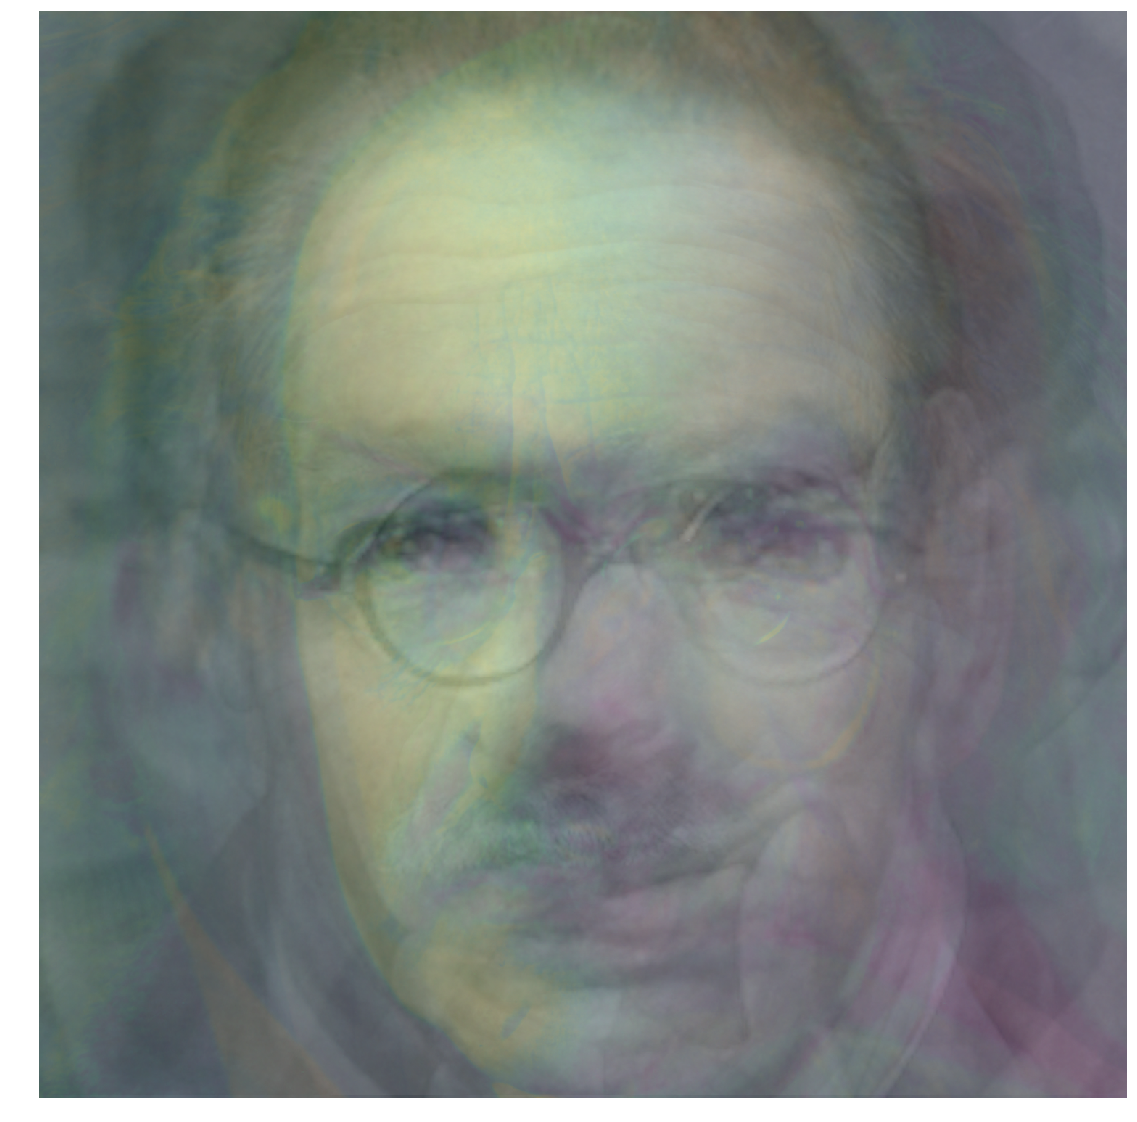

In [10]:
import matplotlib.pyplot as plt

plt.figure(2,figsize=(20,20))

for j in reversed(range(n)):
    image = plt.imread("nobel-winners/"+sorted_strings[j]+".png")
    plt.imshow(image,alpha=alpha[j])
plt.axis('off')
plt.show()